# 샘플 이미지로 이미지 전처리 테스트

In [3]:
# 모듈 import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import re
# os는 파이썬의 내장 모듈 중 하나로, 운영체제와 상호 작용하기 위한 기능을 제공
import os
# shutil은 파일 및 디렉토리 작업을 위한 파이썬의 내장 모듈 중 하나
import shutil
# glob은 파일 경로를 패턴 매칭을 통해 검색하는데 사용되는 파이썬의 내장 모듈 중 하나
import glob
import zipfile
import cv2

이미지 데이터 타입: uint8


Text(0.5, 1.0, 'Resized Image')

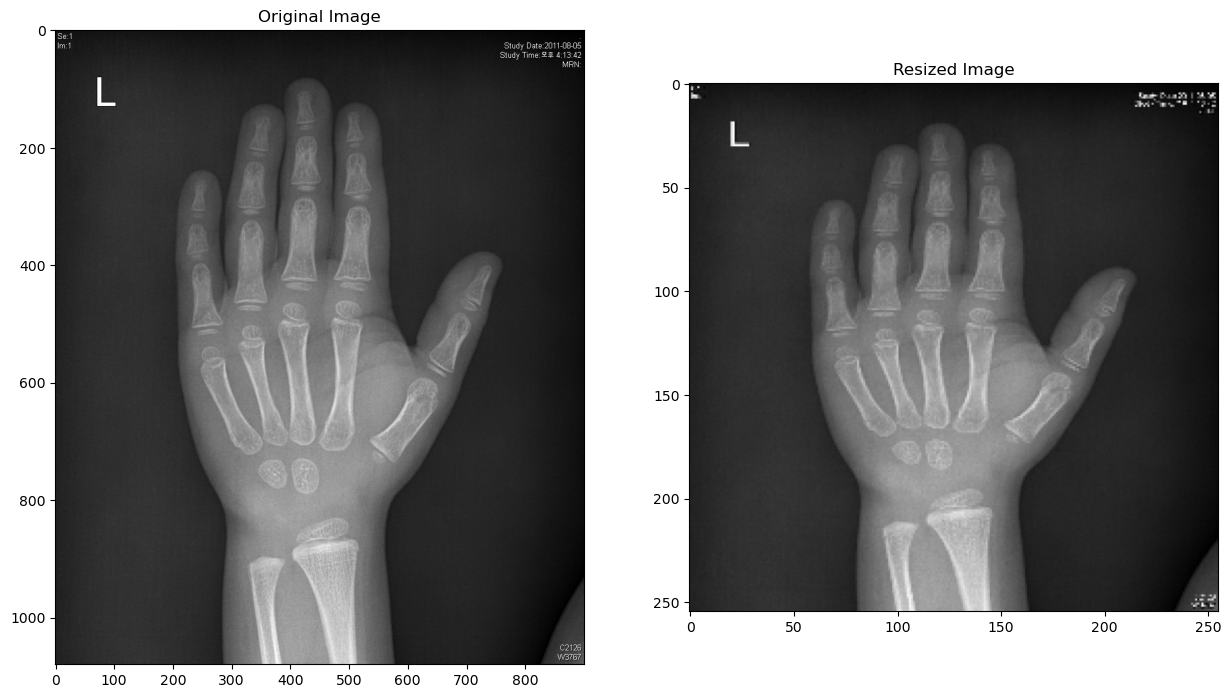

In [4]:
#이미지 불러오고 사이즈 수정

img_path = "/Users/jinwo/OneDrive/바탕 화면/골연령데이터/Data/Images/"
img_sample = plt.imread(img_path + "1_F.jpg", cv2.IMREAD_GRAYSCALE)

#이미지 데이터 타입 확인
print("이미지 데이터 타입:", img_sample.dtype)

#이미지 사이즈 수정
resized_img=cv2.resize(img_sample, (255, 255))

#이미지 확인
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(img_sample, "gray")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(resized_img, "gray")
plt.title("Resized Image")

In [5]:
#배경이미지를 삭제하기 위한 마스크 생성 함수
def make_mask(img_sample):

    img_mask = img_sample.copy()
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_RGB2BGR)
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2Lab)
    
    blur_k = int((img_mask.mean()*0.5)//2)*2+1
    img_mask = cv2.medianBlur(img_mask, blur_k)
    
    ## change to Grayscale for threshold
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_Lab2BGR)
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)

    ## binary / value = img.mean()
    if img_mask.mean() > 100 : 
      th = img_mask.mean()*0.94
    else : 
      th = img_mask.mean()

    ret, img_mask = cv2.threshold(img_mask, th, 255, cv2.THRESH_BINARY)

    ## mask based Max value of contours

    contours, hierarchy = cv2.findContours(img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img_mask.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)
    
    ## Applying for dilation

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (8,8))
    mask = cv2.dilate(mask,k)
    return mask

In [6]:
#마스크를 이용하여 원본이미지의 배경을 자르는 함수
def cut_mask(img_sample, mask):
    img_for_cut = img_sample.copy()
    height, width = img_for_cut.shape[:2]

    ## mask
    mask_list = mask.tolist()
    
    for y in range(int(height*0.05),height):
        if max(mask[y,int(width*0.3):int(width*0.7)]) > 0:
            start_y = y-int(height*0.05)
            break
            
    for x in range(int(width*0.05),width):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            start_x = x-int(width*0.05)
            break
            
    for x in range(int(width*0.95),-1,-1):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            end_x = x+int(width*0.05)
            break
            
    cut_index = 0
    if mask_list[height-1][-1] == 255 or mask_list[height-1][0] == 255:
        for n in reversed(range(height)):
            if mask_list[n][0] == 0 or mask_list[n][-1] == 0:
                cut_index = n
                break
                
    if cut_index == 0:
        cut_index = height

    ## converting color
    img_for_cut = cv2.cvtColor(img_for_cut, cv2.COLOR_BGR2GRAY) 

    img_for_cut = img_for_cut[start_y:(cut_index-1),start_x:end_x]
    mask = mask[start_y:(cut_index-1),start_x:end_x]

    ## remove background
    masked = cv2.bitwise_and(img_for_cut, mask)

    return masked


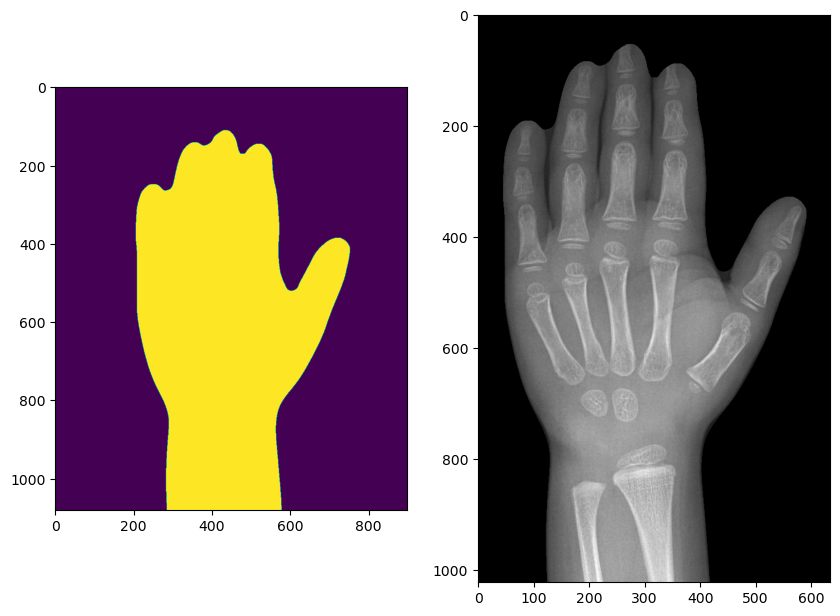

In [7]:
mask = make_mask(img_sample)
masked = cut_mask(img_sample, mask)

plt.figure(figsize=(10, 15))

plt.subplot(1,2,1)
plt.imshow(mask)

plt.subplot(1,2,2)
plt.imshow(masked, cmap="gray")


In [8]:
from sklearn.linear_model import LinearRegression
import math

#마스크씌어진 이미지를 회전시키는 함수
def img_rotation(masked):
    before_rot_img = masked.copy()

    
    h, w = before_rot_img.shape[:2]
    before_rot_img = cv2.cvtColor(before_rot_img, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(before_rot_img, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    th_li = th.tolist()


    for i in reversed(range(h)):
        if th_li[i][0] == 0 and th_li[i][-1] == 0:
            lower = i
            break

    # lower = condition ; bottom = lower / img * 0.95

    if lower == h - 1:
        lower = int(h*0.9)

    # upper = condition ; lower + lower * 0.05

    slice5 = int(len(th)*0.05)
    upper = lower - slice5

    # x, y = between upper and lower (5%) / wrist center

    x,y = [],[]
    for i in range(slice5):
        cnt = th_li[i + upper].count(255)
        index = th_li[i + upper].index(255)
        x.append([i+upper])
        y.append([int((index*2 + cnt - 1)/2)])

    # x, y / draw regression line

    model = LinearRegression()
    model.fit(X=x,y=y)

    ## Rotation stage 02
    angle = math.atan2(h - 0, int(model.predict([[h]])) - int(model.predict([[0]])))*180/math.pi
    M = cv2.getRotationMatrix2D((w/2,h/2), angle-90, 1)
    rotate = cv2.warpAffine(before_rot_img, M, (w, h))

    # Cutting img (rotated img)

    for i in range(len(th[-1])):
        if th[-1][i] == 255:
            start_x = i
            break

    for i in range(len(th[-1])):
        if th[-1][i] == 255:
            end_x = i
            

    s_point = h - int((int(model.predict([[h]])-start_x)) * math.tan(math.pi*((90-angle)/180)))
    e_point = h - int((end_x - int(model.predict([[h]]))) * math.tan(math.pi*((angle-90)/180)))
    point = max(s_point, e_point)
    rotated_img = rotate[:point]
    return rotated_img

In [9]:
#이미지 발기조절, 대비, 필터링 작업으로 뼈 추출하는 함수
def Decomposing(rotated_img,a,b,d,e):
    decomp_img_1 = rotated_img.copy()

    ## brighness
    d_img1 = decomp_img_1.copy()
    cols, rows = d_img1.shape[:2]
    brightness1 = np.sum(d_img1) / (255 * cols * rows)

    if brightness1 > 0.8:
        decomp_img_1 = np.clip(decomp_img_1 - 80., 0, 255).astype(np.uint8)
    elif brightness1 > 0.75:
        decomp_img_1 = np.clip(decomp_img_1 - 50., 0, 255).astype(np.uint8)
    elif brightness1 > 0.65:
        decomp_img_1 = np.clip(decomp_img_1 - 30., 0, 255).astype(np.uint8)
    else: decomp_img_1 = np.clip(decomp_img_1 - 10., 0, 255).astype(np.uint8)


    ## change to Lab
    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_RGB2BGR)
    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_BGR2Lab)

    ## Morphology
    k = cv2.getStructuringElement(cv2.MORPH_CROSS, (a, a))
    decomp_img_1 = cv2.morphologyEx(decomp_img_1, cv2.MORPH_TOPHAT, k) # Emphasis

    ## Filter
    decomp_img_1 = cv2.bilateralFilter(decomp_img_1,-1, d, e)

    ## Lab to gray for binary
    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_Lab2BGR)
    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_BGR2GRAY)

    ## img_normalization
    decomp_img_1 = cv2.normalize(decomp_img_1, None, 0, 255, cv2.NORM_MINMAX)

    ## CLAHE
    decomp_img_1 = cv2.equalizeHist(decomp_img_1)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3,3)) 
    decomp_img_1= clahe.apply(decomp_img_1)          


    ## Threshold / value = img.mean()
    ret, mask = cv2.threshold(decomp_img_1,
                            np.mean(decomp_img_1),
                            255,
                            cv2.THRESH_BINARY) 

    ## Extract object / same value pixels

    contours, hierarchy = cv2.findContours(mask, 
                                            cv2.RETR_EXTERNAL, # only outline
                                            cv2.CHAIN_APPROX_SIMPLE) # Contour vertex coordinate

    ## drawing Contours
    cv2.drawContours(mask, contours, -1, (255,255,255), -1) # -1: 모든 컨트어 표시 /color/ fill

    ##################어렵다 어려워
    decomp_img_2 = rotated_img.copy()

    ## Brightness_Empahsis
    d_img2 = decomp_img_2.copy()
    cols, rows = d_img2.shape[:2]
    brightness2 = np.sum(d_img2) / (255 * cols * rows)

    ## Empahsis
    if brightness2 > 0.8:
        decomp_img_2 = np.clip(decomp_img_2 - 80., 0, 255).astype(np.uint8)
    elif brightness2 > 0.75:
        decomp_img_2 = np.clip(decomp_img_2 - 50., 0, 255).astype(np.uint8)
    elif brightness2 > 0.65:
        decomp_img_2 = np.clip(decomp_img_2 - 30., 0, 255).astype(np.uint8)
    else: decomp_img_2 = np.clip(decomp_img_2 - 10., 0, 255).astype(np.uint8)


    ## Morphology
    k2 = cv2.getStructuringElement(cv2.MORPH_CROSS,(b,b))
    decomp_img_2 = cv2.morphologyEx(decomp_img_2, cv2.MORPH_TOPHAT, k2)

    ## contrast
    decomp_img_2 = cv2.cvtColor(decomp_img_2, cv2.COLOR_BGR2RGB)
    decomp_img_2 = cv2.cvtColor(decomp_img_2, cv2.COLOR_BGR2GRAY)

    if decomp_img_2.mean() <= 15:
        low = decomp_img_2.mean() * 3.2
        high = decomp_img_2.mean() * 3.6
    elif decomp_img_2.mean() <= 20:
        low = decomp_img_2.mean() * 3
        high = decomp_img_2.mean() * 3.6
    else:
        low = decomp_img_2.mean() * 3
        high = decomp_img_2.mean() * 3.7

    decomp_img_2 = cv2.blur(decomp_img_2,(2,2))
    h, w = decomp_img_2.shape
    img_ = np.zeros(decomp_img_2.shape, dtype=np.uint8)

    for y in range(h):
        for x in range(w):
            temp = int((255 / (high - low)) * (decomp_img_2[y][x] - low))
            if temp > 255:
                img_[y][x] = 255
            elif temp < 0:
                img_[y][x] = 0
            else:
                img_[y][x] = temp

    decomp_img_2 = img_.copy()



    ### Bone empahsis / bitwise (mask)
    ## Morphology
    ## Contours
    contours, hierarchy = cv2.findContours(decomp_img_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(decomp_img_2, contours, -1, (255, 255, 255), -1)

    ## Bitwise (mask) / print white parts

    decomp_img_2 = cv2.bitwise_and(decomp_img_2, mask) 

    decomp_img_2 = cv2.cvtColor(decomp_img_2, cv2.COLOR_GRAY2BGR)
    decomp_img_2 = cv2.blur(decomp_img_2,(2,2))

    bone_extraction = cv2.resize(decomp_img_2, (600, 800))

    return bone_extraction


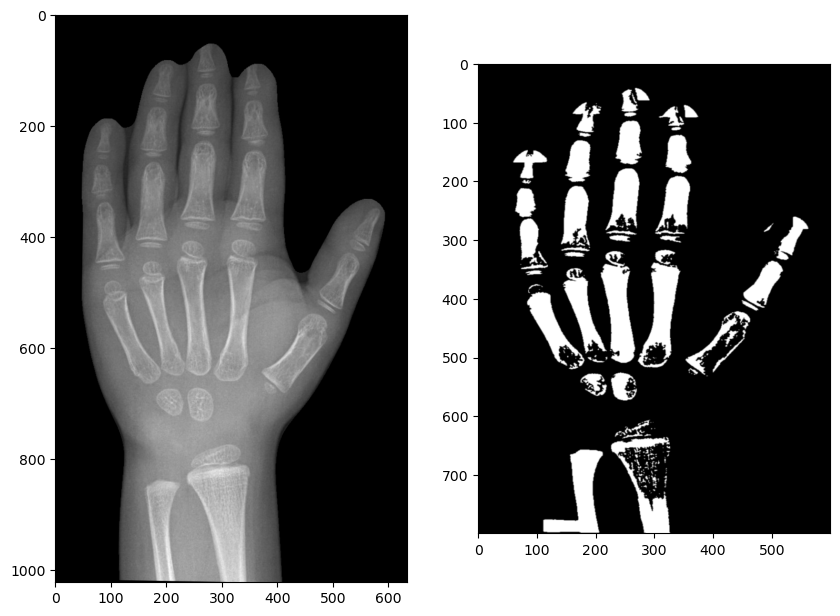

In [10]:
rotation = img_rotation(masked)
decompose = Decomposing(rotation, 60, 55, 50, 25)

plt.figure(figsize=(10,15))

plt.subplot(1,2,1)
plt.imshow(rotation)

plt.subplot(1,2,2)
plt.imshow(decompose)

## 윤곽선 이미지 만들어보기

In [11]:
#위에 회전시킨 이미지 사용
rot_img2 = rotation.copy()


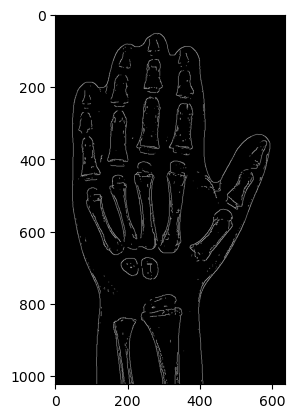

In [12]:
#마스크처리하고 로테이션 된 이미지 활용해서 윤곽선 추출
kernel2 = np.ones((11, 11), np.uint8)
result2 = cv2.morphologyEx(rot_img2, cv2.MORPH_CLOSE, kernel2)
canny_test = cv2.Canny(result2, 50,53)

img_test=canny_test.copy()

plt.imshow(img_test, cmap="gray")

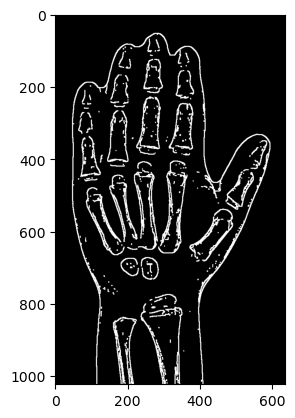

In [13]:
#윤곽선 확대
k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dst = cv2.dilate(img_test, k)
thick_line = dst.copy()

plt.imshow(thick_line, cmap="gray")

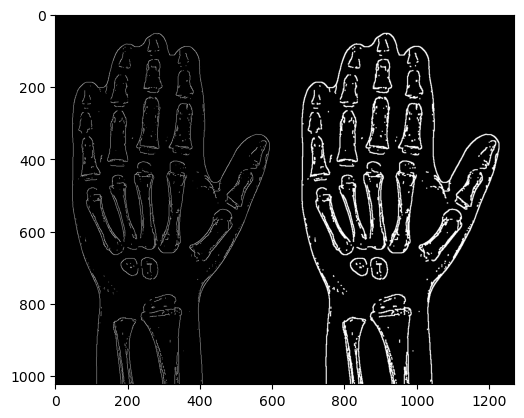

In [14]:
merged = np.hstack((img_test, thick_line))

plt.imshow(merged, cmap="gray")

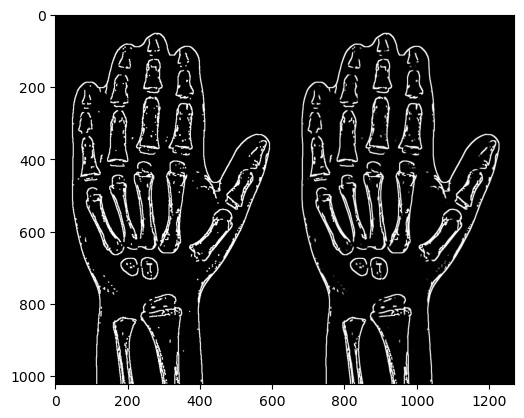

In [15]:
#노이즈 제거
denoised_img = cv2.fastNlMeansDenoising(thick_line, h=50, templateWindowSize = 10, searchWindowSize = 21 )
no_noise = denoised_img.copy()
merged2 = np.hstack((thick_line, no_noise))
plt.imshow(merged2, cmap="gray")

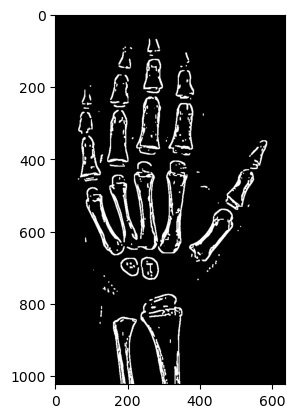

In [16]:
#윤곽선 삭제
im = cv2.normalize(no_noise, None, alpha=0, beta= 255, norm_type = cv2.NORM_MINMAX)
res, im = cv2.threshold(im, 20, 255,cv2.THRESH_BINARY)

cv2.floodFill(im, None, (0,0), 255)
cv2.floodFill(im, None, (0,0), 0)

no_boder = im.copy()
plt.imshow(no_boder, cmap="gray")

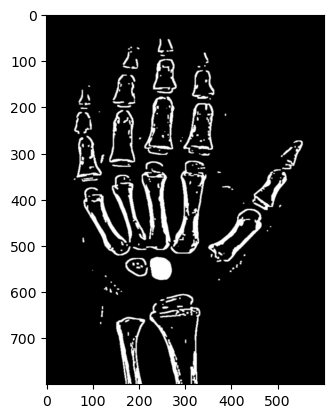

In [17]:
#윤곽선 작업 후 decomposing
decompose2 = Decomposing(no_boder, 60, 55, 50, 25)

plt.imshow(decompose2, cmap="gray")

In [ ]:
## 이미지 전처리 계획
# mask생성 - 배경 이미지 제거 - 이미지 rotation - 이미지 윤곽선 작업 - decomposing
# ?윤곽선 작업을 하고 decomposing을 할까 vs 윤곽선 과정 없이 decomposing을 할까
# roi 추출 -> opencv를 쓸까 vs yolo모델을 쓸까

## roi 추출 test

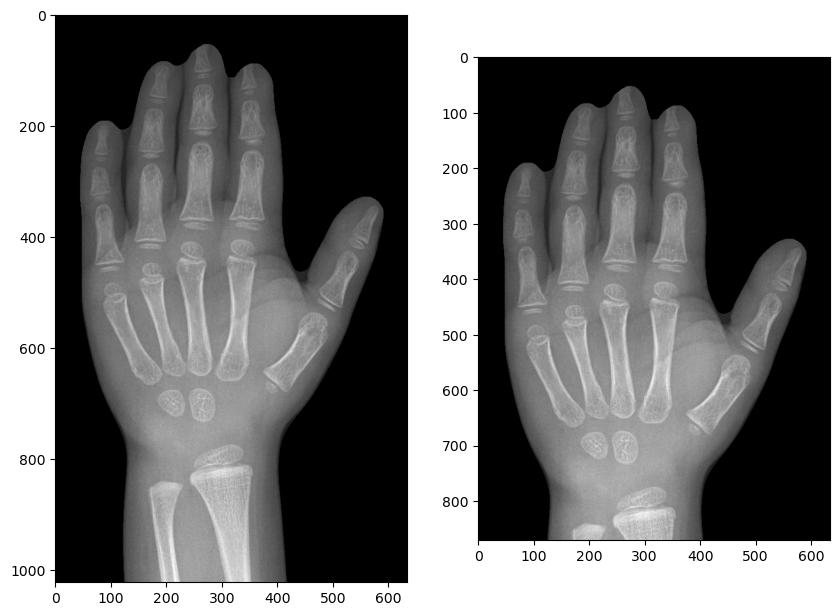

In [18]:
img = masked.copy()

height = img.shape[0]
width = img.shape[1]

#이미지의 아래에서부터 시작해서 화소 평균이 커지는(밝아지는) 경계선 찾기
start = int(height*0.95)  #아래 테두리가 밝은 경우를 고려해서 height*0.95부터 시작함
index = 0
k = 10 #10개 행씩 평균 구함
while True:
    pixel_lower = img[start-k*(index+1):start-k*index,:].mean()
    pixel_upper = img[start-k*(index+2):start-k*(index+1),:].mean()
    if pixel_upper - pixel_lower > 0:
        end_y = start-k*(index+1)
        break
    index += 1
    
cut_wrist = img[:end_y]

plt.figure(figsize=(10, 15))
plt.subplot(1,2,1)
plt.imshow(masked, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(cut_wrist, cmap='gray')
